In [1]:
#%% Import libraries
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import ast
from scipy.ndimage import gaussian_filter
import pickle
import scipy.stats
import os


In [2]:
#%%
errors = np.zeros((768))
its = np.zeros((768))
mts = np.zeros((768))

In [2]:
#%%
def euclidean_dist(df):
    errors = list()
    for i in range(len(df)):
        errors.append(np.sqrt((df['target_x'][i] - df['transfer_mouse.x'][i][-1])**2 + (df['target_y'][i] - df['transfer_mouse.y'][i][-1])**2))        

    return errors       
def angular_dist(vec1, vec2):
    uv1 = vec1/np.linalg.norm(vec1)
    uv2 = vec2/np.linalg.norm(vec2)
    dot_prod = np.dot(uv1, uv2)
    return np.arccos(dot_prod)

def rotate(x, y, angle):
    radians = (np.pi/180)*angle
    cos_val = np.cos(radians)
    sin_val = np.sin(radians)
    nx = x*cos_val + y*sin_val
    ny = y*cos_val - x*sin_val
    return [nx, ny];


# Preprocessing

## 0. Read Data

In [3]:
def data_read(participant):
    return pd.read_csv('data/'+str(participant)+'.csv')

## 1. Data Cleanup 

In [4]:
def data_cleanup(data):
    #Preliminary cleanup. Includes dropping NAs, separating in three sets and resetting indices to start from 0
    data_baseline = data.dropna(subset = ['baseline_mouse.x'], inplace = False)
    data_baseline.dropna('columns', inplace = True)
    data_baseline.reset_index(drop = True, inplace = True)
    
    data_rotated = data.dropna(subset = ['rotated_mouse.x'], inplace = False)
    data_rotated.dropna('columns', inplace = True)
    data_rotated.reset_index(drop = True, inplace = True)
    
    data_transfer = data.dropna(subset = ['transfer_mouse.x'], inplace = False)
    data_transfer.dropna('columns', inplace = True)
    data_transfer.reset_index(drop = True, inplace = True)
    
    #Convert string lists to regular lists
    for column in data_rotated.columns:
        try:
            data_rotated[column] = data_rotated[column].apply(ast.literal_eval)
        except:
            continue
            #print()
    for column in data_baseline.columns:
        try:
            data_baseline[column] = data_baseline[column].apply(ast.literal_eval)
        except:
            continue
            #print()
    for column in data_transfer.columns:
        try:
            data_transfer[column] = data_transfer[column].apply(ast.literal_eval)            
        except:
            continue
            #print()


    return data_baseline, data_rotated, data_transfer

## 2. Reading fixation positions

In [5]:
def get_fix_positions(cleaned_data, participant):
    data_baseline, data_rotated, data_transfer = cleaned_data
    baseline_fix_pos = np.zeros((64, 2))
    for trial in range(64):
        try:
            baseline_fix_pos[trial][:] = np.array(rotate(data_baseline['baseline_mouse.x'][trial][-1], data_baseline['baseline_mouse.y'][trial][-1], 0))        
        except:
            continue
    rotated_fix_pos = np.zeros((640, 2))
    if participant%2 == 0:
        for trial in range(640):
            try:
                rotated_fix_pos[trial][:] = np.array(rotate(data_rotated['rotated_mouse.x'][trial][-1], data_rotated['rotated_mouse.y'][trial][-1], 90))        
            except:
                continue
    else:
        for trial in range(640):
            try:
                rotation = int(trial/64 + 1) * 10
                if rotation > 90:
                    rotation = 90
                #rotation = 0
                #print(rotation)
                rotated_fix_pos[trial][:] = np.array(rotate(data_rotated['rotated_mouse.x'][trial][-1], data_rotated['rotated_mouse.y'][trial][-1], rotation))
            except:
                print (trial)
                continue
                #print()
    transfer_fix_pos = np.zeros((64, 2))
    for trial in range(64):
        try:
            transfer_fix_pos[trial][:] = np.array(rotate(data_transfer['transfer_mouse.x'][trial][-1], data_transfer['transfer_mouse.y'][trial][-1], 0))        
        except:
            continue
            #print()
    return baseline_fix_pos, rotated_fix_pos, transfer_fix_pos

## 3. Calculating euclidean and angular errors

In [6]:
def calc_error(cleaned_data, fix_position):
    data_baseline, data_rotated, data_transfer = cleaned_data
    baseline_fix_pos, rotated_fix_pos, transfer_fix_pos = fix_position
    errors = np.zeros(768)
    ang_errors = np.zeros(768)
    for trial in range(64):
        errors[trial] = np.sqrt((baseline_fix_pos[trial][0] - data_baseline['target_x'][trial])**2 + (baseline_fix_pos[trial][1] - data_baseline['target_y'][trial])**2)
        ang_errors[trial] = angular_dist(baseline_fix_pos[trial], [data_baseline['target_x'][trial], data_baseline['target_y'][trial]])
    for trial in range(640):
        errors[trial+64] = np.sqrt((rotated_fix_pos[trial][0] - data_rotated['target_x'][trial])**2 + (rotated_fix_pos[trial][1] - data_rotated['target_y'][trial])**2)
        ang_errors[trial+64] = angular_dist(rotated_fix_pos[trial], [data_rotated['target_x'][trial], data_rotated['target_y'][trial]])
    for trial in range(64):
        errors[trial+704] = np.sqrt((transfer_fix_pos[trial][0] - data_transfer['target_x'][trial])**2 + (transfer_fix_pos[trial][1] - data_transfer['target_y'][trial])**2)
        ang_errors[trial+704] = angular_dist(transfer_fix_pos[trial], [data_transfer['target_x'][trial], data_transfer['target_y'][trial]])
    return errors, ang_errors

## 4. Pipeline to calculate errors for each participant

In [15]:
def get_errors(participant):
    data = data_read(participant)
    cleaned_data = data_cleanup(data)
    fix_position = get_fix_positions(cleaned_data, participant)
    errors, ang_errors = calc_error(cleaned_data, fix_position)
    #ang_errors = np.nan_to_num(ang_errors, nan = np.nanmean(ang_errors))
    d = {'trial': range(768),
        'errors_temp': errors,
        'ang_errors_temp': ang_errors}
    df = pd.DataFrame(d)
    df['errors'] = df['errors_temp'].interpolate()
    df['ang_errors'] = df['ang_errors_temp'].interpolate()
    return df

In [53]:
ang_errors = np.zeros((10, 768))
errors = np.zeros((10, 768))
for participant in range(2010, 2019):
    errors_df = get_errors(participant)
    ang_errors[participant-2010] = gaussian_filter(errors_df['ang_errors'], sigma = 2)
    errors[participant - 2010] = gaussian_filter(errors_df['errors'], sigma = 2)

<ipython-input-4-396cf816f312>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_baseline.dropna('columns', inplace = True)
<ipython-input-4-396cf816f312>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rotated.dropna('columns', inplace = True)
<ipython-input-4-396cf816f312>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_transfer.dropna('columns', inplace = True)
<ipython-input-4-396cf816f312>:18: SettingWithCopyWarni

448
474


<ipython-input-2-37506489b2d9>:9: RuntimeWarning: invalid value encountered in true_divide
  uv1 = vec1/np.linalg.norm(vec1)
<ipython-input-4-396cf816f312>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_baseline.dropna('columns', inplace = True)
<ipython-input-4-396cf816f312>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rotated.dropna('columns', inplace = True)
<ipython-input-4-396cf816f312>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

126
192
256
320
448


<ipython-input-2-37506489b2d9>:9: RuntimeWarning: invalid value encountered in true_divide
  uv1 = vec1/np.linalg.norm(vec1)
<ipython-input-4-396cf816f312>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_baseline.dropna('columns', inplace = True)
<ipython-input-4-396cf816f312>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rotated.dropna('columns', inplace = True)
<ipython-input-4-396cf816f312>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

476
534


<ipython-input-2-37506489b2d9>:9: RuntimeWarning: invalid value encountered in true_divide
  uv1 = vec1/np.linalg.norm(vec1)
<ipython-input-4-396cf816f312>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_baseline.dropna('columns', inplace = True)
<ipython-input-4-396cf816f312>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rotated.dropna('columns', inplace = True)
<ipython-input-4-396cf816f312>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

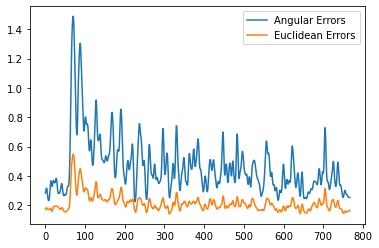

In [61]:
plt_angular, = plt.plot(np.mean(ang_errors[0::2], axis = 0))
plt_euclidean, = plt.plot(np.mean(errors[0::2], axis = 0))
plt.legend((plt_angular, plt_euclidean), ('Angular Errors', "Euclidean Errors"))

# RTs

In [64]:
a, b, c = data_cleanup(data_read(2010))

<ipython-input-4-396cf816f312>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_baseline.dropna('columns', inplace = True)
<ipython-input-4-396cf816f312>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rotated.dropna('columns', inplace = True)
<ipython-input-4-396cf816f312>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_transfer.dropna('columns', inplace = True)
<ipython-input-4-396cf816f312>:18: SettingWithCopyWarni

In [66]:
a.columns

Index(['target_x', 'target_y', 'rotation', 'baseline_trials.thisRepN',
       'baseline_trials.thisTrialN', 'baseline_trials.thisN',
       'baseline_trials.thisIndex', 'baseline_enclosing_1.started',
       'baseline_enclosing_1.stopped', 'baseline_enclosing.started',
       'baseline_enclosing.stopped', 'baseline_target.started',
       'baseline_target.stopped', 'baseline_fixation.started',
       'baseline_fixation.stopped', 'baseline_mouse.x', 'baseline_mouse.y',
       'baseline_mouse.leftButton', 'baseline_mouse.midButton',
       'baseline_mouse.rightButton', 'baseline_mouse.time',
       'baseline_mouse.started', 'baseline_mouse.stopped',
       'baseline_enclosing_feedback_1.started',
       'baseline_enclosing_feedback_1.stopped',
       'baseline_enclosing_feedback.started',
       'baseline_enclosing_feedback.stopped',
       'baseline_target_feedback.started', 'baseline_target_feedback.stopped',
       'baseline_fixation_feedback.started',
       'baseline_fixation_feedba

In [121]:
np.nonzero(np.array(a['baseline_mouse.x'][0]))

(array([ 92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 211, 212, 227, 228, 229, 230, 231, 232, 233, 234,
        235, 236, 237, 238, 239, 240, 241, 242, 243], dtype=int64),)

(array([ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
        236, 237, 238, 239, 240, 241, 242, 243], dtype=int64),)

In [85]:
total_time = gaussian_filter(c['transfer_fixation_feedback.started'] - c['transfer_fixation.started'], sigma = 2)

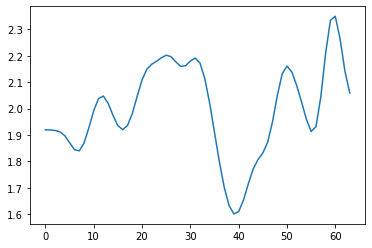

In [86]:
plt.plot(total_time)